In [2]:
import jax.numpy as jnp
import jax

In [3]:
from granad import *

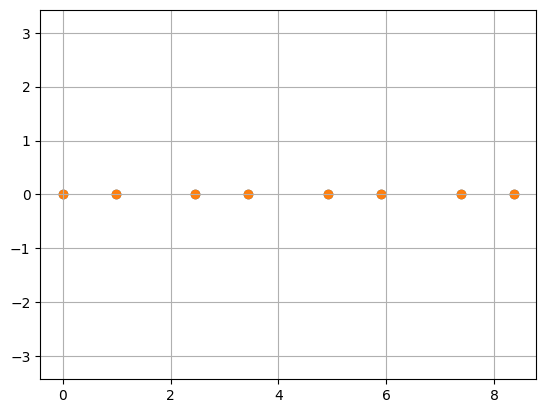

In [4]:
chain_1 = MaterialCatalog.get("ssh", delta = 0.2, displacement = 0.4).cut_flake(unit_cells = 4, plot = True)
del chain_1[-1]
#chain_1.show_2d()

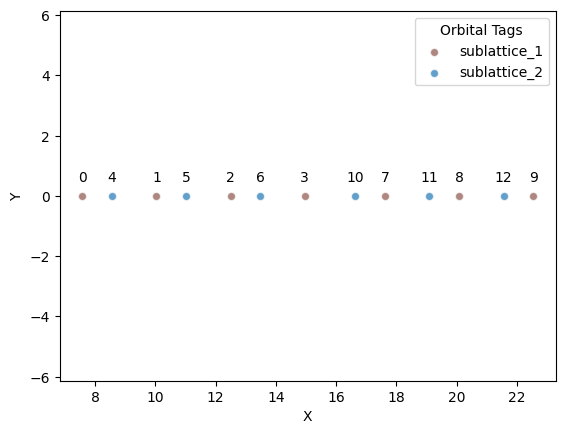

7.0


In [5]:
max_x = chain_1.positions[:, 0].max() + 0.2
chain_2 = MaterialCatalog.get("ssh", delta = 0.2, displacement = 0.6).cut_flake(unit_cells = 4, plot = False )
chain_2.shift_by_vector(jnp.array([max_x, 0, 0]))
del chain_2[-1]
del chain_2[0]
chain = chain_1 + chain_2
chain.shift_by_vector(jnp.array([max_x, 0, 0]))
chain.show_2d(show_index = True)
print(jnp.floor(len(chain_1)))

last_index = chain_1.positions[:, 0].argmax().item()
first_index = chain_2.positions[:, 0].argmin().item()

chain.set_hamiltonian_element(chain_1[last_index], chain_2[first_index], 0.8)

In [6]:
#print(chain.hamiltonian.real)
chain.hamiltonian[3, :]

Array([0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.8+0.j,
       0. +0.j, 0. +0.j, 0. +0.j, 0.8+0.j, 0. +0.j, 0. +0.j],      dtype=complex128)

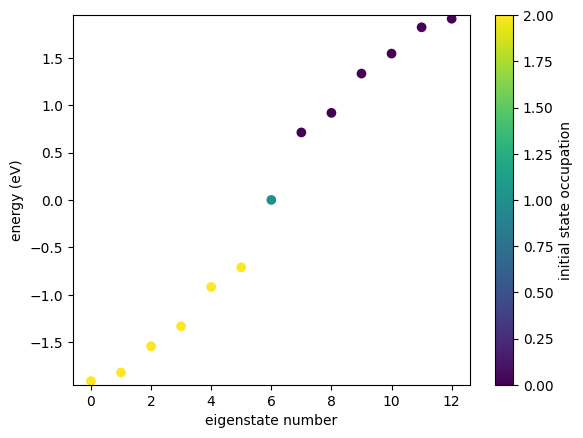

In [7]:
chain.show_energies()

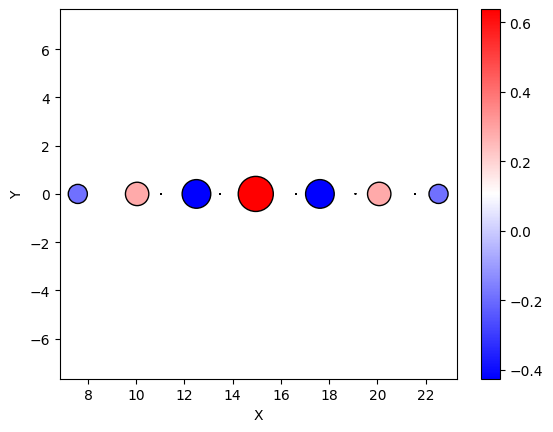

In [8]:
freq = chain.show_2d( display = chain.eigenvectors[:, 6] )

In [9]:
freq = chain.energies[chain.lumo] - chain.energies[chain.homo]
freq


Array(0.71184627, dtype=float64)

In [10]:
pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=freq, peak=5, fwhm=2
)

operators = [chain.dipole_operator]

result = chain.master_equation(
    relaxation_rate = 1/10,
    illumination = pulse,
    expectation_values = operators,
    end_time = 40,
    coulomb_strength = 0,
    grid = 1
     )

RHS compiled
RHS compiled
33.33321315518124 %
66.66660657759063 %
100.0 %


In [11]:
omega_min, omega_max = 0, 4
omegas, pulse_omega = result.ft_illumination( omega_min = omega_min, omega_max = omega_max )
output_omega = result.ft_output( omega_min = omega_min, omega_max = omega_max )[0]

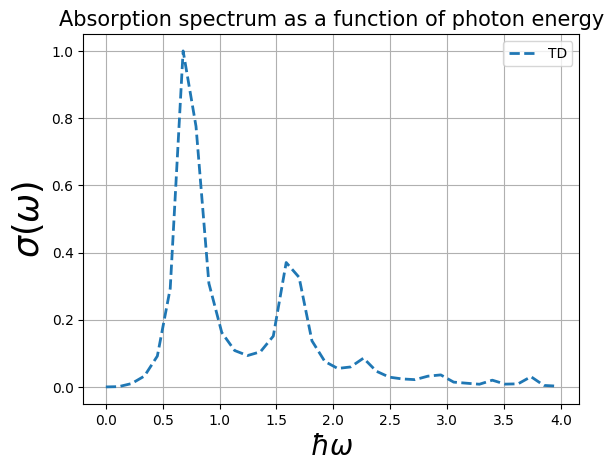

In [12]:
absorption = jnp.abs( -omegas * jnp.imag( output_omega[:,0] / pulse_omega[:,0] ) ) # absorption cross section evaluated based on the time-domain simulation

import matplotlib.pyplot as plt
plt.plot(omegas, absorption / jnp.max(absorption), linewidth=2, ls = '--', label = 'TD' ) 
plt.xlabel(r'$\hbar\omega$', fontsize=20)
plt.ylabel(r'$\sigma(\omega)$', fontsize=25)
plt.title('Absorption spectrum as a function of photon energy', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

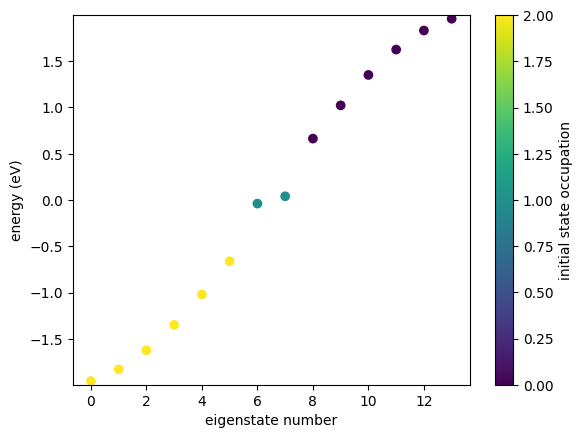

RHS compiled
RHS compiled
14.285637485271915 %
28.57136457105993 %
42.85709165684794 %
57.14281874263596 %
71.42854582842398 %
85.71427291421197 %
100.0 %
-0.03949407889134709 0.0394940788913469
0.1688926736589309 []
0.6192731367494133 [[5, 6], [7, 8]]
1.0696535998398957 [[4, 7], [6, 9]]
1.3511413892714472 []
2.026712083907171 []
2.7022827785428944 [[3, 10]]
3.265258357405998 []
3.71563882049648 []
3.8282339362691005 []
3.9408290520417215 []


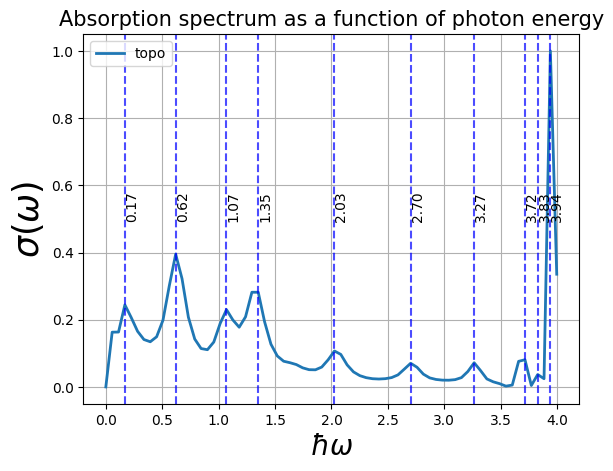

In [13]:
import matplotlib.pyplot as plt

chain_topo = MaterialCatalog.get("ssh", delta = -0.2, displacement = 0.4).cut_flake(unit_cells = 7, plot = False)
chain_topo.set_excitation(chain_topo.homo,chain_topo.lumo,1)
chain_topo.show_energies()
freq = chain.energies[chain.lumo] - chain.energies[chain.homo]

pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=freq, peak=5, fwhm=2
)
operators = [chain_topo.dipole_operator]
#plt.plot(omegas, absorption / jnp.max(absorption),  '--', linewidth=2,label = 'domain') 
result = chain_topo.master_equation(
    relaxation_rate = 1/10,
    illumination = pulse,
    expectation_values = operators,
    end_time = 100,
    coulomb_strength = 0,
    grid = 1
     )
omega_min, omega_max = 0, 4
omegas_topo, pulse_omega = result.ft_illumination( omega_min = omega_min, omega_max = omega_max )
output_omega = result.ft_output( omega_min = omega_min, omega_max = omega_max )[0]
absorption_topo = jnp.abs( -omegas_topo * jnp.imag( output_omega[:,0] / pulse_omega[:,0] ) ) # absorption cross section evaluated based on the time-domain simulation
plt.plot(omegas_topo, absorption_topo / jnp.max(absorption_topo), '-', linewidth=2, label = 'topo') 

plt.xlabel(r'$\hbar\omega$', fontsize=20)
plt.ylabel(r'$\sigma(\omega)$', fontsize=25)
plt.title('Absorption spectrum as a function of photon energy', fontsize=15)
plt.legend()
plt.grid(True)


print(chain_topo.energies[chain_topo.homo], chain_topo.energies[chain_topo.lumo])
delta_e = chain_topo.energies - chain_topo.energies[:, None]
energies = jnp.unique(jnp.abs(delta_e))

def find_peaks(arr):
    return jnp.where((arr[1:-1] > arr[:-2]) & (arr[1:-1] > arr[2:]))[0] + 1

peaks = omegas_topo[find_peaks(absorption_topo)] 
eps = 1e-2
occupied = jnp.argwhere(jnp.round(chain_topo.initial_density_matrix_e.diagonal() * chain_topo.electrons, 8) > eps)
fully_occupied = jnp.argwhere( jnp.abs(jnp.round(chain_topo.initial_density_matrix_e.diagonal() * chain_topo.electrons, 8) - 2) < eps)

delta_e =  jnp.abs(chain_topo.energies - chain_topo.energies[:, None])
for p_idx, p in enumerate(peaks):
    differences = jnp.abs(delta_e - p)
    flat_index = differences.argsort(axis = None)
    res = []
    for i in flat_index:
        row, col = jnp.unravel_index(i, delta_e.shape)
        diffs = jnp.abs(delta_e[row, col] - peaks)
        closest = differences[row, col] == diffs.min()
        if col in occupied and row not in fully_occupied and differences[row, col] < eps and col < row and closest:
            res.append( [col.item(), row.item()] )
    print(p, res)
    plt.axvline(x=p, color='b', linestyle='--', alpha=0.7)
    plt.text(p, 0.5, f'{p:.2f}', rotation=90, fontsize=10)

    #plt.text(p, 0, f'{res}', rotation=90, verticalalignment='bottom', fontsize=10)
    

plt.show()

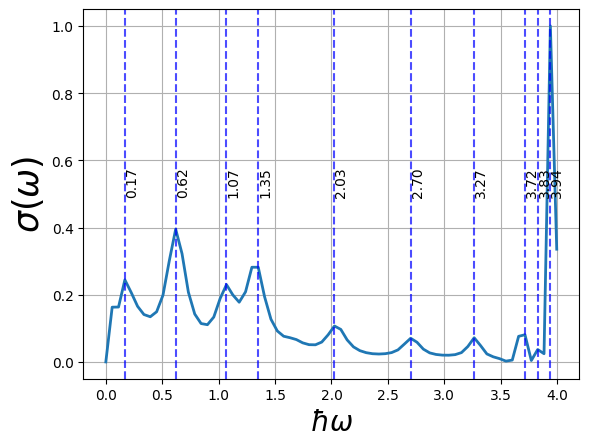

In [14]:
omegas = omegas_topo
spectrum = absorption_topo
pt = chain_topo.show_identified_peaks(omegas, spectrum)

In [15]:
pt

[[Array(0.16889267, dtype=float64), [[6, 7]]],
 [Array(0.61927314, dtype=float64), [[5, 6], [7, 8], [5, 7], [6, 8]]],
 [Array(1.0696536, dtype=float64), [[4, 7], [6, 9], [4, 6], [7, 9]]],
 [Array(1.35114139, dtype=float64),
  [[5, 8], [3, 7], [6, 10], [3, 6], [7, 10]]],
 [Array(2.02671208, dtype=float64),
  [[3, 8], [5, 10], [4, 9], [0, 7], [6, 13]]],
 [Array(2.70228278, dtype=float64),
  [[3, 10], [4, 11], [2, 9], [0, 8], [5, 13]]],
 [Array(3.26525836, dtype=float64),
  [[2, 11], [3, 13], [0, 10], [3, 12], [1, 10]]],
 [Array(3.71563882, dtype=float64), [[1, 12]]],
 [Array(3.82823394, dtype=float64), [[0, 12], [1, 13]]],
 [Array(3.94082905, dtype=float64), [[0, 13]]]]

In [16]:
chain_topo.initial_density_matrix_e.diagonal() * chain_topo.electrons


Array([ 2.00000000e+00+0.j,  2.00000000e+00+0.j,  2.00000000e+00+0.j,
        2.00000000e+00+0.j,  2.00000000e+00+0.j,  2.00000000e+00+0.j,
        1.00000000e+00+0.j,  1.00000000e+00+0.j,  2.82965338e-19+0.j,
       -3.75008226e-17+0.j, -7.34214813e-17+0.j, -1.43561125e-17+0.j,
        1.63618679e-17+0.j,  8.90909241e-17+0.j], dtype=complex128)

In [17]:
flat_index

Array([ 13, 182,  12, 168,  27, 183,  26, 169,  11, 154,  41, 184,  25,
        40, 155, 170,  10, 140,  55, 185,  39, 156,  54, 171,  24, 141,
        69, 186,   9, 126,  53, 157,  38, 142,  68, 172,  23, 127,  52,
       143,  67, 158,  37, 128,   8,  83, 112, 187,  82, 173,  22, 113,
        66, 144,  51, 129,  81, 159,  36, 114,  65, 130,  50, 115,  80,
       145,   7,  98,  97, 188,   6,  84, 111, 189,  96, 174,  21,  99,
       110, 175,  20,  85,  64, 116,  79, 131,  95, 160,  35, 100, 109,
       161,  34,  86,  49,  94, 101, 146,  78, 117,  48,  87, 108, 147,
         5,  70, 125, 190, 124, 176,  19,  71,  63, 102,  93, 132,  62,
        88, 107, 133, 123, 162,  33,  72,   4,  56, 139, 191, 138, 177,
        18,  57,  77,  92, 103, 118,  47,  73, 122, 148,  76,  89, 106,
       119,   3,  42, 153, 192, 137, 163,  32,  58, 152, 178,  17,  43,
        61,  74, 121, 134,   2,  28, 167, 193, 136, 149,  46,  59, 151,
       164,  31,  44,  16,  29, 166, 179,   1,  14, 181, 194,  9

In [18]:
jnp.abs(delta_e - p).argsort()

Array([[13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0],
       [13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  0,  1],
       [13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  0,  3,  1,  2],
       [13, 12, 11, 10,  9,  8,  7,  6,  5,  0,  1,  4,  2,  3],
       [13, 12, 11, 10,  9,  8,  7,  6,  0,  1,  2,  5,  3,  4],
       [13, 12, 11, 10,  9,  8,  0,  1,  2,  7,  3,  6,  4,  5],
       [13,  0, 12,  1, 11,  2, 10,  3,  9,  4,  8,  5,  7,  6],
       [ 0, 13,  1, 12,  2, 11,  3, 10,  4,  9,  5,  8,  6,  7],
       [ 0,  1,  2,  3,  4,  5, 13, 12, 11,  6, 10,  7,  9,  8],
       [ 0,  1,  2,  3,  4,  5,  6,  7, 13, 12, 11,  8, 10,  9],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 12,  9, 11, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 13, 10, 12, 11],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]],      dtype=int64)

In [19]:
differences

Array([[3.94082905, 3.81352932, 3.60791162, 3.33377375, 3.00534547,
        2.64627716, 2.02341432, 1.94442616, 1.32156332, 0.962495  ,
        0.63406673, 0.35992885, 0.15431116, 0.02701142],
       [3.81352932, 3.94082905, 3.73521136, 3.46107348, 3.13264521,
        2.77357689, 2.15071405, 2.07172589, 1.44886305, 1.08979474,
        0.76136646, 0.48722859, 0.28161089, 0.15431116],
       [3.60791162, 3.73521136, 3.94082905, 3.66669118, 3.3382629 ,
        2.97919459, 2.35633175, 2.27734359, 1.65448075, 1.29541243,
        0.96698415, 0.69284628, 0.48722859, 0.35992885],
       [3.33377375, 3.46107348, 3.66669118, 3.94082905, 3.61240077,
        3.25333246, 2.63046962, 2.55148146, 1.92861862, 1.56955031,
        1.24112203, 0.96698415, 0.76136646, 0.63406673],
       [3.00534547, 3.13264521, 3.3382629 , 3.61240077, 3.94082905,
        3.58176074, 2.9588979 , 2.87990974, 2.2570469 , 1.89797858,
        1.56955031, 1.29541243, 1.08979474, 0.962495  ],
       [2.64627716, 2.77357689, 2.9